In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers, callbacks

file_path = "scaled_multiclass.csv"

df = dk.read_csv(file_path)
import matplotlib.pyplot as plt
# Đếm số lượng mỗi nhãn

label_counts = df['label'].value_counts().compute()
print(label_counts)
"""
ordered_labels = [0,1]
ordered_counts = [label_counts.get(label,0) for label in ordered_labels]

labels = ["Benign", "Malicious"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, ordered_counts, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()
"""

2025-06-02 09:42:59.987510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 09:43:00.045786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748832180.099622    3476 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748832180.114709    3476 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748832180.169949    3476 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

label
3     486504
1    4000000
4     317183
0    1098195
2    2634124
Name: count, dtype: int64


'\nordered_labels = [0,1]\nordered_counts = [label_counts.get(label,0) for label in ordered_labels]\n\nlabels = ["Benign", "Malicious"]\n# Vẽ biểu đồ cột\nplt.figure(figsize=(9, 5))\nplt.bar(labels, ordered_counts, color=\'skyblue\', edgecolor=\'black\')\nplt.xlabel("Nhãn (Classes)")\nplt.ylabel("Số lượng mẫu (Frequency)")\nplt.title("Tỷ lệ nhãn trong Dataset")\nplt.xticks(range(len(labels)) ,labels, rotation =45)\nplt.show()\n'

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/core.py:8153: UserWarning: Insufficient elements for `head`. 8000000 elements requested, only 65164 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [2]:
"""
Kiểm tra dataset sau khi xử lý
"""
#df = dk.read_csv("single_file.csv")

# Tính tổng số mẫu
total_samples = df.shape[0].compute()
print(f"Tổng số mẫu: {total_samples}")
    
# Tính phân bố label
label_counts = df['label'].value_counts().compute()
print("Phân bố label:")
print(label_counts.sort_index())
    
# Kiểm tra số lượng label liên tiếp
df_small = df.head(8000000)
labels = df_small['label'].values
max_consecutive = current = 1  

for i in range(1, len(labels)):
    if labels[i] == labels[i-1]:
        current += 1
        max_consecutive = max(max_consecutive, current)
    else:
        current = 1  # Reset bộ đếm khi label thay đổi

print(f"Chuỗi liên tiếp dài nhất trong 11 triệu mẫu đầu: {max_consecutive}")


Tổng số mẫu: 8536006
Phân bố label:
label
0    1098195
1    4000000
2    2634124
3     486504
4     317183
Name: count, dtype: int64
Chuỗi liên tiếp dài nhất trong 11 triệu mẫu đầu: 622


In [3]:
#Global var 
batch_size = 512
ratio_test_all = 0.20

from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
'''
def standardize_dask_df(dask_df):
    scaler = StandardScaler()
    X = dask_df.drop(columns=['label']).compute().values
    scaler.fit(X)
    for part in dask_df.to_delayed():
        part = part.compute()
        if part.empty:
            continue
        X_part = part.drop(columns=['label']).values
        X_scaled = scaler.transform(X_part)
        part.iloc[:, :-1] = X_scaled
        yield part

scaled_parts = list(standardize_dask_df(df))
scaled_df = dk.from_pandas(pd.concat(scaled_parts), npartitions=df.npartitions)
scaled_df.to_csv("scaled_output.csv", single_file=True, index=False)
print("Đã in thành công")
'''
train_df, val_test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.85, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
    

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [4]:
train_gen = dask_to_tf_dataset(train_df, 512).repeat()
test_gen = dask_to_tf_dataset(test_df, 512)
val_gen = dask_to_tf_dataset(val_df, 512).repeat()

I0000 00:00:1748832216.461773    3476 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
import math
n_samples =  np.ceil(train_df.shape[0])
steps_per_epoch = int(n_samples / (batch_size))
validation_steps = int(steps_per_epoch / (16))
print("Steps/Epoch: ", steps_per_epoch)
num_samples_test = test_df.shape[0].compute()
# Tính số batch
num_batches_test = int(np.ceil(num_samples_test / batch_size))
print("Batch test: ", num_batches_test)

Steps/Epoch:  13341
Batch test:  2832


In [6]:
from datetime import datetime, timedelta
import sys, os
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
# output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras

start_time = datetime.now()
"""
model = keras.Sequential([
    layers.Input(shape=input_shape),
    #layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.05)),
    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.5), 
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax')
])

model = keras.Sequential([
    layers.Input(shape=input_shape),
    #layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.05)),
    layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"),
    #layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax')
])"""
model = models.Sequential([
    layers.Input(shape=input_shape),
    
    # Tầng Conv1D đầu tiên
    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu", 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    # Tầng Conv1D thứ hai
    layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu", 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    # Tầng Conv1D thứ ba
    layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    # Dropout để chống overfitting
    layers.Dropout(0.3),
    
    # Làm phẳng dữ liệu
    layers.Flatten(),
    
    # Tầng Dense đầu tiên
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Tầng Dense thứ hai
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    
    # Tầng đầu ra
    layers.Dense(5, activation='softmax')  # 5 lớp
])
adam_optimizer = optimizers.Adam(learning_rate=1e-5)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Theo dõi loss trên tập validation
    patience=5,          # Dừng sau 5 epoch nếu không cải thiện
    restore_best_weights=True
)
model.compile(optimizer= adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import CSVLogger
os.makedirs("log_mono", exist_ok=True)
log_name = "log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv"
csv_logger = CSVLogger(log_name , append=True)
model.fit(train_gen, epochs=30, validation_data=val_gen, validation_steps= validation_steps , steps_per_epoch= steps_per_epoch, verbose = 1, callbacks=[early_stopping, csv_logger])


end_time = datetime.now()
simulated_time = end_time - start_time
model_name = "saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
# Lưu mô hình
model.save(model_name)

print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        94,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,621 (373.52 KB)

 Trainable params: 95,365 (372.52 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/30


I0000 00:00:1748832250.130066    3557 service.cc:152] XLA service 0x7f8cb801cf60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748832250.130106    3557 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-06-02 09:44:10.185483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748832250.398095    3557 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-02 09:44:11.626516: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 356 bytes spill stores, 356 bytes spill loads

2025-06-02 09:44:11.669619: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

   71/13341 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.2442 - loss: 1.9428

I0000 00:00:1748832254.251429    3557 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-02 09:44:15.105585: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 172 bytes spill stores, 172 bytes spill loads

2025-06-02 09:44:15.275744: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943_0', 164 bytes spill stores, 164 bytes spill loads

2025-06-02 09:44:15.410370: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 356 bytes spill stores, 356 bytes spill loads

2025-06-02 09:44:15.535688: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

   91/13341 ━━━━━━━━━━━━━━━━━━━━ 8:01 36ms/step - accuracy: 0.2526 - loss: 1.9208

2025-06-02 09:44:18.356539: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943_0', 164 bytes spill stores, 164 bytes spill loads

2025-06-02 09:44:18.583108: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 140 bytes spill stores, 140 bytes spill loads

2025-06-02 09:44:19.039531: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 172 bytes spill stores, 172 bytes spill loads

2025-06-02 09:44:19.072713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 292 bytes spill stores, 292 bytes spill loads

2025-06-02 09:44:19.102523: I exte

  604/13341 ━━━━━━━━━━━━━━━━━━━━ 3:04 15ms/step - accuracy: 0.4269 - loss: 1.5581

2025-06-02 09:44:23.984582: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943_0', 164 bytes spill stores, 164 bytes spill loads

2025-06-02 09:44:24.148767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 356 bytes spill stores, 356 bytes spill loads

2025-06-02 09:44:24.184319: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 292 bytes spill stores, 292 bytes spill loads

2025-06-02 09:44:24.301700: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 140 bytes spill stores, 140 bytes spill loads

2025-06-02 09:44:24.327489: I exte

  699/13341 ━━━━━━━━━━━━━━━━━━━━ 3:39 17ms/step - accuracy: 0.4482 - loss: 1.5141

2025-06-02 09:44:27.264476: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 356 bytes spill stores, 356 bytes spill loads

2025-06-02 09:44:27.469088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 292 bytes spill stores, 292 bytes spill loads

2025-06-02 09:44:27.550432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943_0', 164 bytes spill stores, 164 bytes spill loads

2025-06-02 09:44:27.572989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 100 bytes spill stores, 100 bytes spill loads

2025-06-02 09:44:27.642913: I exte

  708/13341 ━━━━━━━━━━━━━━━━━━━━ 4:29 21ms/step - accuracy: 0.4501 - loss: 1.5102

2025-06-02 09:44:30.193043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 28 bytes spill stores, 28 bytes spill loads

2025-06-02 09:44:30.426803: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943_0', 20 bytes spill stores, 20 bytes spill loads

2025-06-02 09:44:30.490736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 80 bytes spill stores, 80 bytes spill loads

2025-06-02 09:44:30.562097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 660 bytes spill stores, 660 bytes spill loads



  903/13341 ━━━━━━━━━━━━━━━━━━━━ 4:33 22ms/step - accuracy: 0.4865 - loss: 1.4334

2025-06-02 09:44:35.220676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943_0', 164 bytes spill stores, 164 bytes spill loads

2025-06-02 09:44:35.326877: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 356 bytes spill stores, 356 bytes spill loads

2025-06-02 09:44:35.344417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 172 bytes spill stores, 172 bytes spill loads

2025-06-02 09:44:35.355659: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_943', 100 bytes spill stores, 100 bytes spill loads

2025-06-02 09:44:35.391678: I exte

13341/13341 ━━━━━━━━━━━━━━━━━━━━ 149s 11ms/step - accuracy: 0.8069 - loss: 0.6082 - val_accuracy: 0.9409 - val_loss: 0.1492
Epoch 2/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 122s 9ms/step - accuracy: 0.9321 - loss: 0.1983 - val_accuracy: 0.9454 - val_loss: 0.1377
Epoch 3/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 122s 9ms/step - accuracy: 0.9392 - loss: 0.1687 - val_accuracy: 0.9476 - val_loss: 0.1313
Epoch 4/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 120s 9ms/step - accuracy: 0.9425 - loss: 0.1557 - val_accuracy: 0.9493 - val_loss: 0.1271
Epoch 5/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 118s 9ms/step - accuracy: 0.9442 - loss: 0.1481 - val_accuracy: 0.9502 - val_loss: 0.1240
Epoch 6/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 121s 9ms/step - accuracy: 0.9458 - loss: 0.1422 - val_accuracy: 0.9508 - val_loss: 0.1222
Epoch 7/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 120s 9ms/step - accuracy: 0.9467 - loss: 0.1383 - val_accuracy: 0.9513 - val_loss: 0.1208
Epoch 8/30
13341/13341 ━━━━━━━━━━━━━━━━━━━━ 119s 9ms/step - accuracy: 0.

In [7]:
from tensorflow.keras.models import load_model
#model_name = "saved_model/cnn_model_2-0_batch512_11h59p__27-05-2025.keras"
model = load_model(model_name)

output = model.evaluate(test_gen, steps = num_batches_test)
print(f'Loss: {output[0]} Acc: {output[1]}')

2832/2832 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.9568 - loss: 0.1128
Loss: 0.11357062309980392 Acc: 0.9568431973457336


2025-06-02 10:45:39.079912: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-02 10:45:39.080220: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-06-02 10:45:39.080228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4276439489838283417
2025-06-02 10:45:39.080252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7886989895350981294
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function whe

Số lượng mẫu y_true_all: 1449945
Số lượng mẫu y_pred_all: 1449945
Precision: 0.8777907436671348
Recall: 0.8425175799417804
F1-Score: 0.8566394729706589


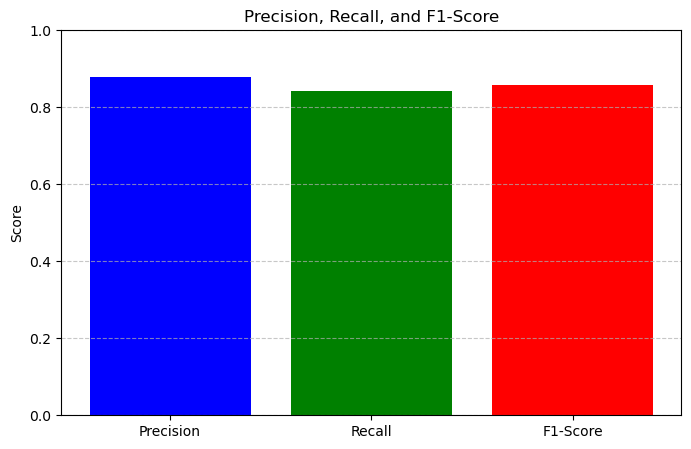

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load mô hình
model = load_model(model_name)

# Khởi tạo danh sách để lưu nhãn thực tế và nhãn dự đoán
y_true_all = []
y_pred_all = []

# Lặp qua các batch trong test_gen
for X_batch, y_batch in test_gen.take(num_batches_test):
    # Chuyển nhãn thực tế thành danh sách và làm phẳng
    y_true = y_batch.numpy()
    if len(y_true.shape) > 1:  # Nếu y_batch có dạng (batch_size, num_classes)
        y_true = np.argmax(y_true, axis=1)  # Chuyển từ one-hot hoặc xác suất thành nhãn
    else:
        y_true = y_true.flatten()  # Đảm bảo làm phẳng nếu cần
    y_true_all.extend(y_true)

    # Dự đoán với mô hình
    y_pred_prob = model.predict(X_batch, verbose=0)
    # Chuyển xác suất thành nhãn bằng argmax (cho phân loại đa lớp)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_pred_all.extend(y_pred)

# Kiểm tra số lượng mẫu
print("Số lượng mẫu y_true_all:", len(y_true_all))
print("Số lượng mẫu y_pred_all:", len(y_pred_all))

# Tính các chỉ số đánh giá
precision = precision_score(y_true_all, y_pred_all, average='macro')
recall = recall_score(y_true_all, y_pred_all, average='macro')
f1 = f1_score(y_true_all, y_pred_all, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Vẽ biểu đồ
param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

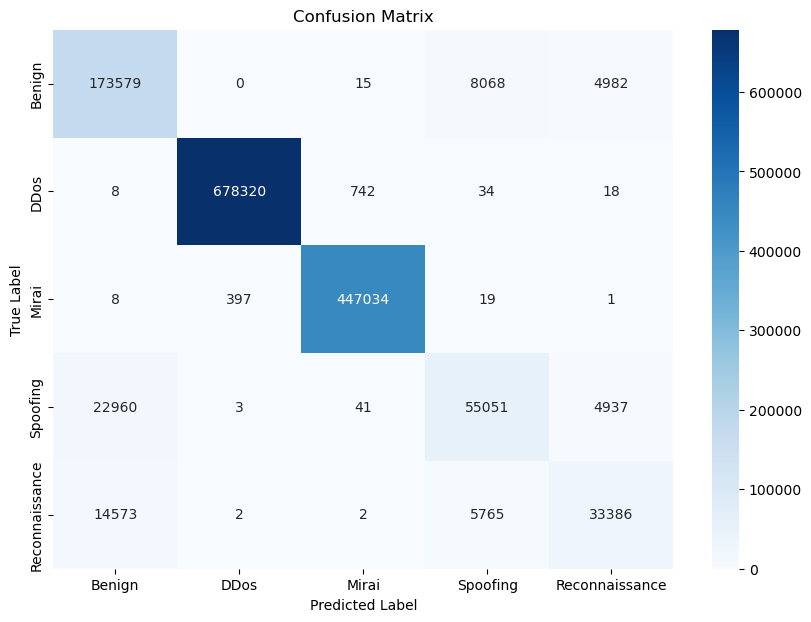

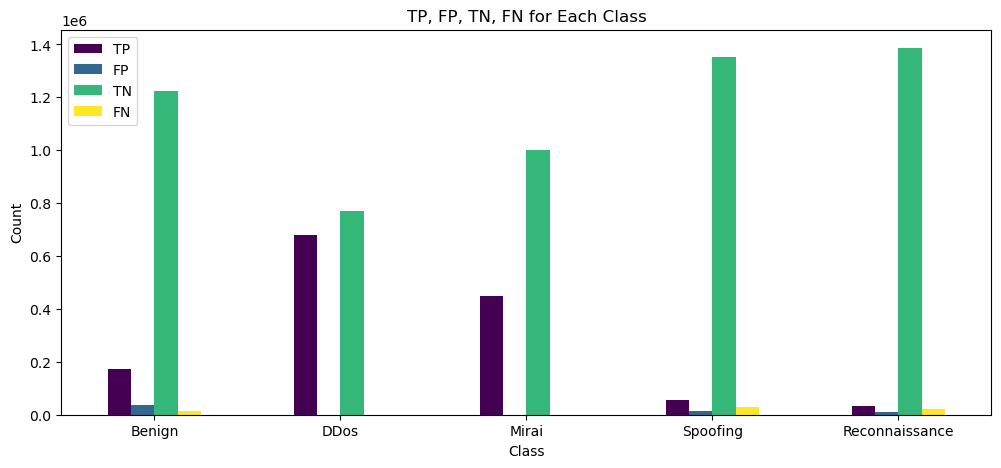

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

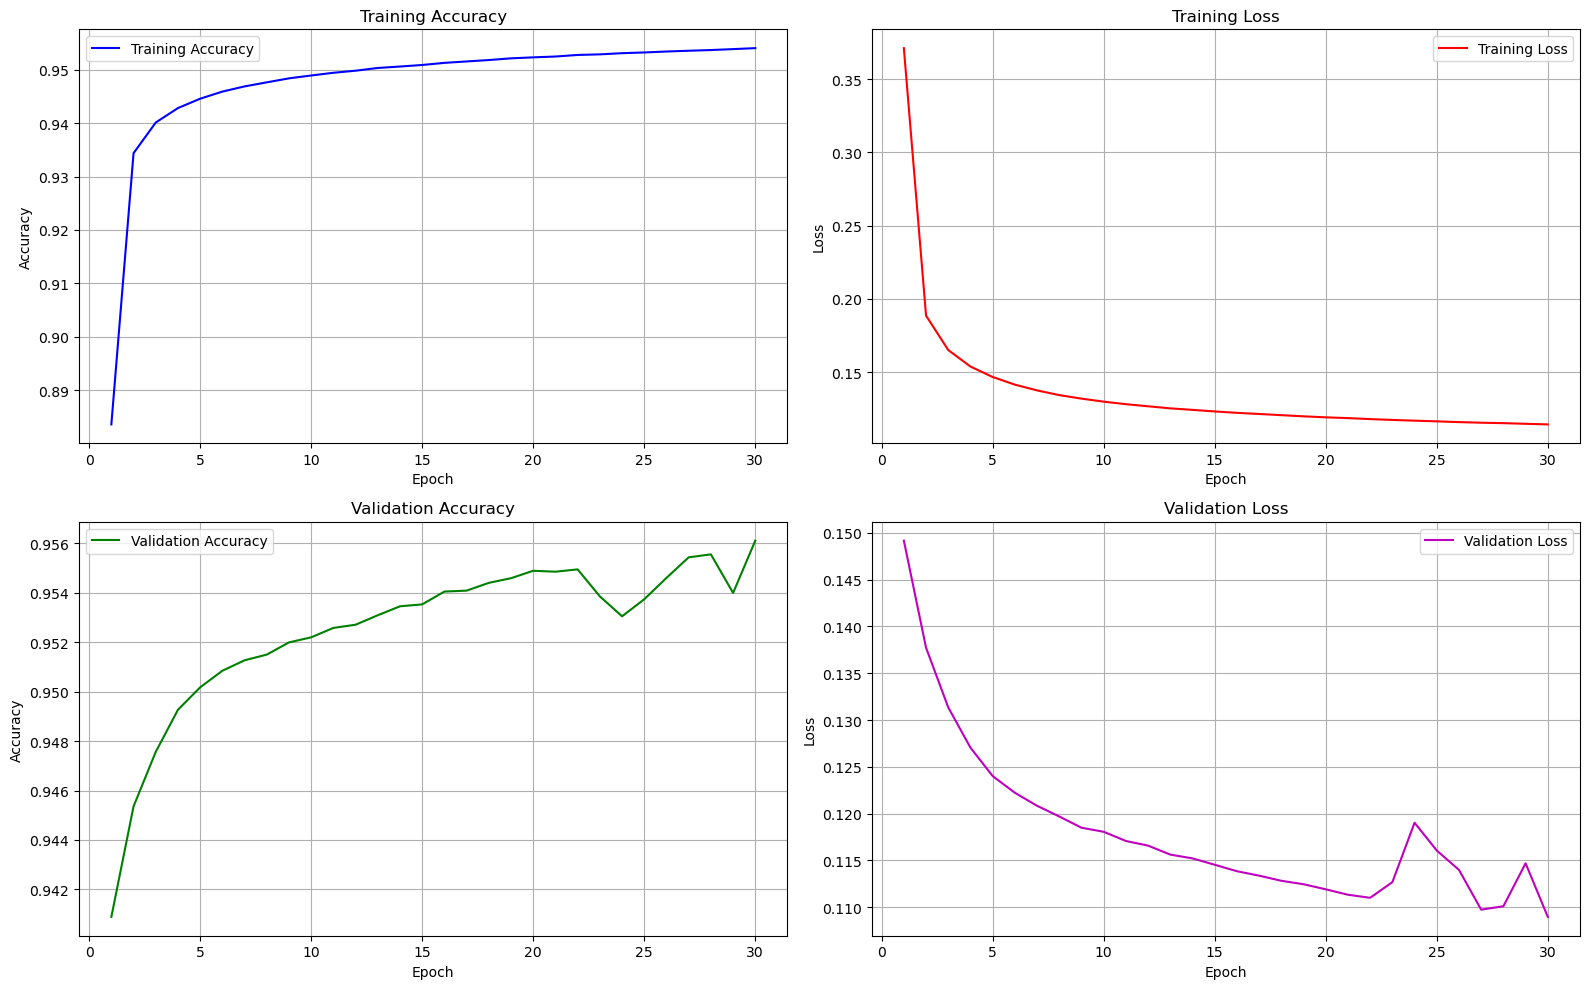

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc log từ file CSV
log_df = pd.read_csv(log_name)  # Đổi tên file nếu cần

epochs = range(1, len(log_df) + 1)

plt.figure(figsize=(16, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
#plt.ylim(0.40, 1.0)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
#plt.ylim(0.95, 1.0)

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib  # Để lưu scaler

# Đọc dataset huấn luyện
X_train = df.drop(columns=['label']).values  # Loại bỏ cột label
print(X_train)
# Fit scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Lưu scaler vào file
joblib.dump(scaler, 'scaler.pkl')
print("Scaler đã được huấn luyện và lưu vào 'scaler.pkl'")

dask.array<values, shape=(nan, 46), dtype=float64, chunksize=(nan, 46), chunktype=numpy.ndarray>
Scaler đã được huấn luyện và lưu vào 'scaler.pkl'
